# Holdouts Evaluation - Amazon Digital Music
sample from 2014-06 until 2016-11 with 6M cold start incl. only positive rates (4 and 5 *)

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

# imports

In [2]:
import pandas as pd 
import joblib
from sklearn.preprocessing import MinMaxScaler


from dataset_evaluation_utils import get_namepaths
from data_utils import load_data_print_info

from data import ImplicitData, getBucketsHoldouts
from eval_implicit import EvaluateHoldouts, EvalPrequential 
from recommenders_implicit import ISGD

from plot_utils import recall_heatmap
from data_utils.transfer_learning_scores import *

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# import plotly.offline as py
# pd.options.plotting.backend = "plotly"
# py.init_notebook_mode() # graphs charts inline (IPython).

a4_dims = (11.7, 8.27)

# functions

In [3]:
def read_all_reclists_to_frame(filename:str, n_holdouts:int, rec_list_as_rows:bool=False):
    '''
        filename: expects 'path/to/file/<file_name>'
                    string is completed with '_b<i>_h<j>.joblib' in this function
                    full string rule : 'path/to/file/<file_name>_b<i>_h<j>.joblib'

                  the file shape is assumed to be 
                    [ 
                        [ ['B001PZ06PS' '0.5036084630168064']
                          ['B001386NZE' '0.504954758011992']
                          ['B00PJU8VFM' '0.5300628103145297'] ... ],
                        [ ... ], 
                      ... 
                    ]

                    
        if rec_list_as_rows: returns a pd.Dataframe like so
                                            0	          1	          2          # rank of item in the Top N Rec List
        bucket_idx	bucket_idx	reclist_idx			
        b0	        h0	        0.0	        B00PBW27VW  B00RDEZFN8	B009G3S0F4 # 1st list of rec items of '<file_name>_b0_h0.joblib'
                                1.0	        B00PBW27VW	B00RDEZFN8	B009G3S0F4
                    h1	        0.0	        B00SYTTBMC	B00KJJS6HQ	B001L0TTS2
                                1.0	        B00SYTTBMC	B00KJJS6HQ	B001L0TTS2
                                2.0	        B00SYTTBMC	B00KJJS6HQ	B001L0TTS2
                                3.0	        B00SYTTBMC	B00KJJS6HQ	<item_id>
        else: returns
                                              item_id
        bucket_idx	holdout_idx	reclist_idx	
        b0	        h0	        0	            B001PZ06PS
                                0	            B001386NZE
                                0	            B00PJU8VFM
                                0	            B00PBW27VW
                                0	            B00RDEZFN8
        
    
    '''
        
    fileshape = (0,20,2)
    n = fileshape[1]
    all_rec_lists = np.empty(fileshape, dtype=object)
    # rec_lists_b0_h0 = joblib.load(filename+'_b0_h0.joblib')
    # n = len(rec_lists_b0_h0[0]) # len(all_rec_lists.T[0].T[0]) would also work
    # rs = np.empty((0, rec_lists_b0_h0.shape[1], rec_lists_b0_h0.shape[2]))

    df_bucket_idxs = []
    df_holdout_idxs = []
    df_reclist_idxs = []


    if rec_list_as_rows:

      for bucket_i in range(n_holdouts):
        print(bucket_i)
        for holdout_j in range(n_holdouts):

          reclists_bi_hj = np.array(joblib.load(filename+'_b'+str(bucket_i)+'_h'+str(holdout_j)+'.joblib'),  dtype=object)
          
          # with different len arrays, np array becomes 1d, raises an error when merging later on
          # when 1d, it means there are empty rec lists
          # solution, reshape those so the array has shape (20, 2)
          if reclists_bi_hj.ndim == 1:
            reclists_bi_hj = np.array([np.empty((20,2), dtype=object) if l==[] else l for l in reclists_bi_hj])

          n_reclists = len(reclists_bi_hj)

          df_bucket_idxs = np.concatenate([df_bucket_idxs, ['b'+str(bucket_i)]*n_reclists*n])
          df_holdout_idxs = np.concatenate([df_holdout_idxs, ['h'+str(holdout_j)]*n_reclists*n])
          df_reclist_idxs = np.concatenate([df_reclist_idxs, np.array(range(n_reclists), dtype=str)])

          all_rec_lists = np.vstack([all_rec_lists, reclists_bi_hj])
          # print(all_rec_lists)

      df_idxs = np.array([df_bucket_idxs, df_holdout_idxs, df_reclist_idxs])
      df = pd.DataFrame(all_rec_lists.T[0].T, index=list(df_idxs), columns=list(range(n)))
      df.index.set_names(['bucket_idx', 'holdout_idx', 'reclist_idx'], inplace=True)
    
      print('how many rec lists are empty: (empty: True)')
      print(df.T.isna().value_counts()/df.shape[0])

    else:

      for bucket_i in range(n_holdouts):
          print(bucket_i)
          for holdout_j in range(n_holdouts):
            # print(bucket_i, holdout_j)

            reclists_bi_hj = np.array(joblib.load(filename+'_b'+str(bucket_i)+'_h'+str(holdout_j)+'.joblib'),  dtype=object)
            
            # with different len arrays, np array becomes 1d, raises an error when merging later on
            # when 1d, it means there are empty rec lists
            # solution, reshape those so the array has shape (20, 2)
            if reclists_bi_hj.ndim == 1:
              reclists_bi_hj = np.array([np.empty((20,2), dtype=object) if l==[] else l for l in reclists_bi_hj])

            # print(reclists_bi_hj.shape)
            n_reclists = len(reclists_bi_hj)

            df_bucket_idxs = np.concatenate([df_bucket_idxs, ['b'+str(bucket_i)]*n_reclists*n])
            df_holdout_idxs = np.concatenate([df_holdout_idxs, ['h'+str(holdout_j)]*n_reclists*n])
            # df_reclist_idxs = np.concatenate([df_reclist_idxs, np.array(range(n_reclists), dtype=str)])
            df_reclist_idxs = np.concatenate([df_reclist_idxs, np.array(np.repeat(range(n_reclists), n), dtype=str)])

            all_rec_lists = np.vstack([all_rec_lists, reclists_bi_hj])
            # print(all_rec_lists)


      df_idxs = np.array([df_bucket_idxs, df_holdout_idxs, df_reclist_idxs])
      shape = all_rec_lists.T[0].T.shape
      df = pd.DataFrame(all_rec_lists.T[0].T.reshape(shape[0]*shape[1]), index=list(df_idxs), columns=['item_id'])
      df.index.set_names(['bucket_idx', 'holdout_idx', 'reclist_idx'], inplace=True)

    df.sort_index(inplace=True)
    return df


In [4]:
def get_user_profile_div_frame(user_div_col:str, 
                               user_profile_size_col:str, 
                               model_data:ImplicitData, 
                               bucket_idx:str, 
                               meta_df:pd.DataFrame):
    # user_div_col = 'user_n_brands'
    # user_profile_size_col = 'n_seen_items'

    user_profile_cols = ['bucket_idx', 'user_id', user_profile_size_col, user_div_col]
    # user_profile_div_df = pd.DataFrame(columns=user_profile_cols)
    user_profile_div = np.empty((0, len(user_profile_cols)), dtype=object)

    for u in (model_data.userset):
        # df (bucket_idx, u, n_seen_items, sum=diversity)
        user_profile = model_data.GetUserItems(u, internal=False)
        # div = meta_df.loc[meta_df['item_id'].isin(user_profile), 'n_brand'].sum()
        div = meta_df.loc[meta_df['item_id'].isin(user_profile), user_div_col].sum()
        user_profile_div = np.vstack([user_profile_div, np.array([bucket_idx, u, len(user_profile), div])])

    return pd.DataFrame(user_profile_div, columns=user_profile_cols)




def get_column_binned(df, col_name, cut=False):
    ''' 
        this function adds a new column to the given dataframe
    '''

    try:
        df[col_name] = df[col_name].astype(int)
    except:
        print('@get_column_binned(): Aborted! Needs to be a column dtype int!')
        raise

    if cut:
        try:
            _, b = pd.cut(df[col_name], 4, retbins=True, labels=False)
        except:
            try:
                _, b = pd.cut(df[col_name], 3, retbins=True, labels=False)
            except:
                _, b = pd.cut(df[col_name], 4, retbins=True, labels=False, duplicates='drop')

    else:
        try:
            _, b = pd.qcut(df[col_name], 4, retbins=True, labels=False)
        except:
            try:
                _, b = pd.qcut(df[col_name], 3, retbins=True, labels=False)
            except:
                _, b = pd.qcut(df[col_name], 4, retbins=True, labels=False, duplicates='drop')

    col_bin_name = col_name+'_binned'
    df[col_bin_name] =  b[1:][_]

    return col_bin_name #, df




def get_avg_recdiv_per_bin(df, rec_div_col, bin_col):
    try:
        df[rec_div_col] = df[rec_div_col].astype(int)
    except:
        print('@get_avg_recdiv_per_bin(): Aborted! Needs to be a column dtype int!')
        raise

    avg_recdiv_bin_col = 'avg_'+rec_div_col+'_per_'+bin_col
    avg_recdiv_per_bin = df[['bucket_idx','holdout_idx',bin_col, rec_div_col]]\
                            .groupby(['bucket_idx','holdout_idx', bin_col])\
                                .mean().reset_index()
    avg_recdiv_per_bin.columns = ['bucket_idx','holdout_idx',bin_col, avg_recdiv_bin_col]
    return avg_recdiv_per_bin, avg_recdiv_bin_col




def validate_folderpath(folderpath):
    if not os.path.exists(folderpath):
        os.makedirs(folderpath)


def save_plot(title, bi, hj, df, x, y, path):
    full_title = title+'- B'+str(bi)+'H'+str(hj)
    # islice = pd.IndexSlice
    # ax = df.loc[islice['b'+str(bi), 'h'+str(hj), :], [x, y]]\
    # _ = df.loc[(df.bucket_idx=='b'+str(bi)) & (df.holdout_idx=='h'+str(hj)), :]
    ax = df.loc[(df.bucket_idx=='b'+str(bi)) & (df.holdout_idx=='h'+str(hj)), [x, y]]\
                .plot(  x=x,
                        y=y,
                        kind='scatter',
                        marker='+',
                        # xunits=UnitData(list(_[x].unique())),
                        title=full_title)
    fig = ax.get_figure()
    fig.savefig(path+full_title+'.png')
    plt.close(fig)
    

# variables

In [5]:
sample = 'sample_2014-06_until_2016-11+cold_start_positive_rates'
sample_foldername = sample+'/'
dump_foldername ='amazon_digmusic_dump/'

# rule: what/which_data_set/sample_version/what/
images_path = 'images/'+dump_foldername+sample_foldername+'diversity_eval/'

# the ADM is too chaoticly organized in output folder, still follows deprecated organization rule: what/which_data_set/what/sample_version
output_path = 'output/'+dump_foldername
diversity_filepath = output_path+'diversity_eval/'+sample_foldername
validate_folderpath(images_path)
validate_folderpath(diversity_filepath)


sample_year_month = [('2014-06', '%Y-%m'), ('2016-11', '%Y-%m')]
interval_type = 'S'
cold_start_buckets = 1
sample_str = 'sample_2014-06_until_2016-11+cold_start_positive_rates_fu_0.75_semesterly'


n_holdouts = 4

div_col = 'n_brand'
meta_dm = pd.read_csv(output_path+'meta_amazon_digitalmusic.csv')
meta_dm.columns = ['item_id', div_col, 'brand']


drop_user_empty_profiles = False

In [6]:
all_reclist_df = read_all_reclists_to_frame(filename=diversity_filepath+'rec_lists',
                                            n_holdouts=n_holdouts)

0
1
2
3


In [14]:
len(set(meta_dm.item_id.unique()).intersection(all_reclist_df.item_id.unique()))

2064

In [15]:
meta_dm.item_id.nunique()

49233

In [16]:
all_reclist_df.item_id.nunique()

38757

# STAGE: load all recommended lists to frame

In [6]:
#########################################################################################
print('STAGE: load all recommended lists to frame')
all_reclist_df = read_all_reclists_to_frame(filename=diversity_filepath+'rec_lists',
                                            n_holdouts=n_holdouts)

total_n_reclists = len(all_reclist_df.index.drop_duplicates())
# n_holdouts = len(all_reclist_df.index.levels[0])

# print('add side info to rec list frame')
meta_rec_df = pd.merge(all_reclist_df.reset_index(), 
                    meta_dm, 
                    how='left')


# print('fill in Na values')
meta_rec_df.loc[meta_rec_df['item_id'].isna(), 'item_id'] = '0'
meta_rec_df.loc[meta_rec_df[div_col].isna(), div_col] = 0
meta_rec_df.loc[meta_rec_df.brand.isna(), 'brand'] = '0'

# print('scale diversity column between 0 and 1')
div_col_minmax = div_col+'_minmax'
scaler = MinMaxScaler(feature_range=(0,1))
meta_rec_df[div_col_minmax] = scaler.fit_transform(meta_rec_df[[div_col]])

STAGE: load all recommended lists to frame
0


1
2
3


# STAGE: calculate the recommended lists diversity 
(aka intra list diversity)

In [7]:
#########################################################################################
print('STAGE: calculate the recommended lists diversity aka intra list diversity')
reclist_div_df = meta_rec_df[['bucket_idx','holdout_idx','reclist_idx',div_col]]\
                .groupby(['bucket_idx','holdout_idx','reclist_idx'])\
                    .sum().reset_index()
rec_div_col = 'intra_list_n_brands'
reclist_div_df.columns = ['bucket_idx','holdout_idx','reclist_idx', rec_div_col]

# print('scale intra list diversity column between 0 and 1')
rec_div_col_minmax = rec_div_col+'_minmax'
scaler = MinMaxScaler(feature_range=(0,1))
reclist_div_df[rec_div_col_minmax] = scaler.fit_transform(reclist_div_df[[rec_div_col]])

STAGE: calculate the recommended lists diversity aka intra list diversity


# STAGE: create diversity df

In [8]:
#########################################################################################
print('STAGE: create diversity df')

# sort the frame, so the user in the holdout oaired with the respective recommended list
# (so the order of the holdouts user list is compatible with it)
reclist_div_df['reclist_idx'] = reclist_div_df['reclist_idx'].astype(int)
reclist_div_df.set_index(['bucket_idx','holdout_idx','reclist_idx'], inplace=True)
reclist_div_df.sort_index(inplace=True)

user_div_col = 'user_n_brands'
user_profile_size_col = 'n_seen_items'
user_profile_cols = ['bucket_idx', 'user_id', user_profile_size_col, user_div_col]
user_profile_div = np.empty((0, len(user_profile_cols)), dtype=object)

# index slice to access multi-index
islice = pd.IndexSlice

# initialize user id column
reclist_div_df['user_id'] = None

holdouts = joblib.load(output_path+sample_str+'_holdouts.joblib')
for hj, holdoutj in enumerate(holdouts): 

    # load user profile @holdout_j -> read model that has seen all *buckets* until *jth holdout*, aka bj
    model_data_bucketj = joblib.load(diversity_filepath+'model_data_b'+str(hj)+'.joblib')
    print('\tcalculate user diversity @'+str(hj))
    for u in (model_data_bucketj.userset):
        # df (bucket_idx, u, n_seen_items, sum=diversity)
        user_profile = model_data_bucketj.GetUserItems(u, internal=False)
        div = meta_dm.loc[meta_dm['item_id'].isin(user_profile), 'n_brand'].sum()
        user_profile_div = np.vstack([user_profile_div, np.array(['b'+str(hj), u, len(user_profile), div])])

    print('\tadd user to the respective rec lists @'+str(hj))
    for bi in range(n_holdouts):
        # reclist_div_df['user_id'] = h.userlist
        reclist_div_df.loc[islice['b'+str(bi), 'h'+str(hj), :], 'user_id'] = list(holdoutj.userlist)
    

user_profile_div_df = pd.DataFrame(user_profile_div, columns=user_profile_cols)
diversity_df = pd.merge(reclist_div_df.reset_index(),
                        user_profile_div_df,
                        how='left')


print('\nNA count')
print('rec_div_col ('+str(rec_div_col)+') ',diversity_df[rec_div_col].isna().sum())
print('rec_div_col_minmax ('+str(rec_div_col_minmax)+') ',diversity_df[rec_div_col_minmax].isna().sum())
print('user_profile_size_col ('+str(user_profile_size_col)+') ',diversity_df[user_profile_size_col].isna().sum())
print('user_div_col ('+str(user_div_col)+') ',diversity_df[user_div_col].isna().sum())

if drop_user_empty_profiles:
    diversity_df = diversity_df.loc[~diversity_df[user_profile_size_col].isna(), :]
else:
    for col in [rec_div_col, rec_div_col_minmax, user_profile_size_col, user_div_col]:
        diversity_df.loc[diversity_df[col].isna(), col] = '0'

print('\n')
print('rec_div_col ('+str(rec_div_col)+') ',diversity_df[rec_div_col].isna().sum())
print('rec_div_col_minmax ('+str(rec_div_col_minmax)+') ',diversity_df[rec_div_col_minmax].isna().sum())
print('user_profile_size_col ('+str(user_profile_size_col)+') ',diversity_df[user_profile_size_col].isna().sum())
print('user_div_col ('+str(user_div_col)+') ',diversity_df[user_div_col].isna().sum())




STAGE: create diversity df
	calculate user diversity @0
	add user to the respective rec lists @0
	calculate user diversity @1
	add user to the respective rec lists @1
	calculate user diversity @2
	add user to the respective rec lists @2
	calculate user diversity @3
	add user to the respective rec lists @3

NA count
rec_div_col (intra_list_n_brands)  0
rec_div_col_minmax (intra_list_n_brands_minmax)  0
user_profile_size_col (n_seen_items)  3288
user_div_col (user_n_brands)  3288


rec_div_col (intra_list_n_brands)  0
rec_div_col_minmax (intra_list_n_brands_minmax)  0
user_profile_size_col (n_seen_items)  0
user_div_col (user_n_brands)  0


# STAGE: bin columns

In [9]:
#########################################################################################
print('STAGE: bin columns - Qcut')

# USER PROFILE
user_profile_size_bin_col = get_column_binned(diversity_df, user_profile_size_col)

# min max
_, avg_recdiv_profilebin_col_minmax = get_avg_recdiv_per_bin(diversity_df,
                                                             rec_div_col_minmax, 
                                                             user_profile_size_bin_col)
diversity_df = pd.merge(diversity_df, _)

# not scaled
_, avg_recdiv_profilebin_col = get_avg_recdiv_per_bin(diversity_df,
                                                      rec_div_col, 
                                                      user_profile_size_bin_col)
diversity_df = pd.merge(diversity_df, _)




# USER DIVERSITY
user_div_bin_col = get_column_binned(diversity_df, user_div_col)

# minmax
_, avg_recdiv_userdivbin_col_minmax = get_avg_recdiv_per_bin(diversity_df,
                                                                rec_div_col_minmax, 
                                                                user_div_bin_col)
diversity_df = pd.merge(diversity_df, _)

# not scaled
_, avg_recdiv_userdivbin_col = get_avg_recdiv_per_bin(diversity_df,
                                                        rec_div_col, 
                                                        user_div_bin_col)
diversity_df = pd.merge(diversity_df, _)


STAGE: bin columns


# STAGE: plot diversity values

In [10]:
#########################################################################################
print('STAGE: plot diversity values')
for bi in range(n_holdouts):
    for hj in range(n_holdouts):
        save_plot(title='Profile size vs Avg intra-list diversity (standardized)',
                  bi=bi,
                  hj=hj,
                  df=diversity_df,
                  x=user_profile_size_bin_col,
                  y=avg_recdiv_userdivbin_col_minmax,
                  path=images_path)
        
        save_plot(title='Profile size vs Avg intra-list diversity',
                  bi=bi,
                  hj=hj,
                  df=diversity_df,
                  x=user_profile_size_bin_col,
                  y=avg_recdiv_userdivbin_col,
                  path=images_path)
        
        save_plot(title='User diversity vs Avg intra-list diversity',
                  bi=bi,
                  hj=hj,
                  df=diversity_df,
                  x=user_div_bin_col,
                  y=avg_recdiv_userdivbin_col,
                  path=images_path)
        
        save_plot(title='User diversity vs Avg intra-list diversity (standardized)',
                  bi=bi,
                  hj=hj,
                  df=diversity_df,
                  x=user_div_bin_col,
                  y=avg_recdiv_userdivbin_col_minmax,
                  path=images_path)                          

STAGE: plot diversity values


In [9]:
#########################################################################################
print('STAGE: bin columns - CUT')

# USER PROFILE
user_profile_size_bin_col = get_column_binned(diversity_df, user_profile_size_col, cut=True)

# min max
_, avg_recdiv_profilebin_col_minmax = get_avg_recdiv_per_bin(diversity_df,
                                                             rec_div_col_minmax, 
                                                             user_profile_size_bin_col)
diversity_df = pd.merge(diversity_df, _)

# not scaled
_, avg_recdiv_profilebin_col = get_avg_recdiv_per_bin(diversity_df,
                                                      rec_div_col, 
                                                      user_profile_size_bin_col)
diversity_df = pd.merge(diversity_df, _)




# USER DIVERSITY
user_div_bin_col = get_column_binned(diversity_df, user_div_col, cut=True)

# minmax
_, avg_recdiv_userdivbin_col_minmax = get_avg_recdiv_per_bin(diversity_df,
                                                                rec_div_col_minmax, 
                                                                user_div_bin_col)
diversity_df = pd.merge(diversity_df, _)

# not scaled
_, avg_recdiv_userdivbin_col = get_avg_recdiv_per_bin(diversity_df,
                                                        rec_div_col, 
                                                        user_div_bin_col)
diversity_df = pd.merge(diversity_df, _)



#########################################################################################
print('STAGE: plot diversity values')
images_path = 'images/'+dump_foldername+sample_foldername+'using_cut()/'+'diversity_eval/'
validate_folderpath(images_path)

for bi in range(n_holdouts):
    for hj in range(n_holdouts):
        save_plot(title='Profile size vs Avg intra-list diversity (standardized)',
                  bi=bi,
                  hj=hj,
                  df=diversity_df,
                  x=user_profile_size_bin_col,
                  y=avg_recdiv_userdivbin_col_minmax,
                  path=images_path)
        
        save_plot(title='Profile size vs Avg intra-list diversity',
                  bi=bi,
                  hj=hj,
                  df=diversity_df,
                  x=user_profile_size_bin_col,
                  y=avg_recdiv_userdivbin_col,
                  path=images_path)
        
        save_plot(title='User diversity vs Avg intra-list diversity',
                  bi=bi,
                  hj=hj,
                  df=diversity_df,
                  x=user_div_bin_col,
                  y=avg_recdiv_userdivbin_col,
                  path=images_path)
        
        save_plot(title='User diversity vs Avg intra-list diversity (standardized)',
                  bi=bi,
                  hj=hj,
                  df=diversity_df,
                  x=user_div_bin_col,
                  y=avg_recdiv_userdivbin_col_minmax,
                  path=images_path)  

STAGE: bin columns - CUT
STAGE: plot diversity values


__________
# from now on is the test code
same as above, but bit by bit

In [3]:
sample = 'sample_2014-06_until_2016-11+cold_start_positive_rates'


sample_year_month = [('2014-06', '%Y-%m'), ('2016-11', '%Y-%m')]
interval_type = 'S'
dump_filename ='amazon_digmusic_dump'
cold_start_buckets = 1

use_data_unique_users = False
frequent_users_thr = 0.75
to_grid_search = False
num_factors = 100
num_iter = 6
learn_rate = 0.1
regularization = 0.1
random_seed = 10

In [4]:
namepaths = get_namepaths(data_name = '_positive_rates_amazon_digitalmusic',
                          data_print_name = 'Amazon Digital Music',
                          sample_year_month = sample_year_month,
                          interval_type = interval_type,
                          dump_filename = dump_filename,
                          frequent_users_thr = frequent_users_thr,
                          cold_start_buckets = cold_start_buckets,
                          use_data_unique_users = use_data_unique_users,
                          to_grid_search = to_grid_search,
                          num_factors = num_factors,
                          num_iter = num_iter,
                          learn_rate = learn_rate,
                          regularization = regularization,
                          random_seed = random_seed,
                          model_print_name = 'ISGD')
namepaths

{'sample_str': '2014-06_until_2016-11+cold_start_fu_0.75',
 'dataset_name': 'sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic',
 'user_col': 'user_id',
 'item_col': 'item_id',
 'output_path': 'output/amazon_digmusic_dump/',
 'data_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic.csv',
 'use_data_unique_users': False,
 'frequent_users_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_frequent_users_0.75.joblib',
 'cold_start_buckets': 1,
 'to_grid_search': False,
 'num_factors': 100,
 'num_iter': 6,
 'learn_rate': 0.1,
 'regularization': 0.1,
 'random_seed': 10,
 'interval_type': 'S',
 'intervals_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_fu_0.75_semestres.joblib',
 'bucket_freq': 'semesterly',
 'buckets_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_fu_0.75_semesterly_buckets.joblib',
 'holdouts_path': 'output/am

In [5]:
# data = load_data_print_info(namepaths['data_path'])

In [6]:
diversity_filepath = namepaths['output_path']+'eval_files/sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic/'

# read rec list for buck 0 holdout 0

In [7]:
rec_lists_b0_h0 = joblib.load(diversity_filepath+'rec_lists_b0_h0.joblib')
print(rec_lists_b0_h0[0])
print('number of rec lists:', len(rec_lists_b0_h0))

[['B001PZ06PS' '0.5036084630168064']
 ['B001386NZE' '0.504954758011992']
 ['B00PJU8VFM' '0.5300628103145297']
 ['B00PBW27VW' '0.5339717351154083']
 ['B00RDEZFN8' '0.5367134409011927']
 ['B009G3S0F4' '0.5513772036287757']
 ['B00T6LGM8I' '0.5687287247543856']
 ['B001IOX1XU' '0.5718044552327285']
 ['B00HB3K55O' '0.5758350167539408']
 ['B00138C98E' '0.5761612550263624']
 ['B00658KG9G' '0.5805775107869356']
 ['B0012QP330' '0.5886001586757581']
 ['B00FZ11C0G' '0.5955553326482207']
 ['B00C3JARCC' '0.5974429158090512']
 ['B00IGIZUGW' '0.5982248029754619']
 ['B00AI3KG0I' '0.6026388892645813']
 ['B00SYTTBMC' '0.6076058554699273']
 ['B00KJJS6HQ' '0.6084093523470404']
 ['B001L0TTS2' '0.6134002633706033']
 ['B00PJU9YSA' '0.6139947052274874']]
number of rec lists: 3382


In [8]:
set([l==[] for l in rec_lists_b0_h0]) # no empty rec list (at a 1st glance)

{False}

# Convert it in dataframe

--- 
proof code works

In [9]:
# # proof code works
# r = np.array([['B00SYTTBMC', '0.6076058554699273'],
#               ['B00KJJS6HQ', '0.6084093523470404'],
#               ['B001L0TTS2', '0.6134002633706033']])

# a = [['0']*len(r), ['0']*len(r)] # [['a', 'a', 'a'], ['a', 'a', 'a']]
# raT = np.concatenate([a, r.T])
# print(raT)
# print()
# print(raT.T)



# rr = np.array([[['B00SYTTBMC', '0.6076058554699273'],
#                 ['B00KJJS6HQ', '0.6084093523470404'],
#                 ['B001L0TTS2', '0.6134002633706033']],

#              [['B00SYTTBMC', '0.6076058554699273'],
#               ['B00KJJS6HQ', '0.6084093523470404'],
#               ['B001L0TTS2', '0.6134002633706033']],

#              [['B00SYTTBMC', '0.6076058554699273'],
#               ['B00KJJS6HQ', '0.6084093523470404'],
#               ['B001L0TTS2', '0.6134002633706033']],

#              [['B00SYTTBMC', '0.6076058554699273'],
#               ['B00KJJS6HQ', '0.6084093523470404'],
#               ['B001L0TTS2', '0.6134002633706033']]])

# i = np.array(range(len(rr)))

# a = np.array([['b0', 'b0', 'b0', 'b0'], ['h0', 'h0', 'h0', 'h0'], i])
# d = pd.DataFrame(rr.T[0].T, index=list(a), columns=['rank1', 'rank2', 'rank3'])
# d.index.set_names(['B', 'H', 'reclist_idx'], inplace=True)
# d

In [10]:
# import numpy as np
# rr = np.array([[['B001PZ06PS', '0.5036084630168064'],
#                 ['B001386NZE', '0.504954758011992'],
#                 ['B00PJU8VFM', '0.5300628103145297'],
#                 ['B00PBW27VW', '0.5339717351154083'],
#                 ['B00RDEZFN8', '0.5367134409011927'],
#                 ['B009G3S0F4', '0.5513772036287757'],
#                 ['B00T6LGM8I', '0.5687287247543856'],
#                 ['B001IOX1XU', '0.5718044552327285'],
#                 ['B00HB3K55O', '0.5758350167539408'],
#                 ['B00138C98E', '0.5761612550263624'],
#                 ['B00658KG9G', '0.5805775107869356'],
#                 ['B0012QP330', '0.5886001586757581'],
#                 ['B00FZ11C0G', '0.5955553326482207'],
#                 ['B00C3JARCC', '0.5974429158090512'],
#                 ['B00IGIZUGW', '0.5982248029754619'],
#                 ['B00AI3KG0I', '0.6026388892645813'],
#                 ['B00SYTTBMC', '0.6076058554699273'],
#                 ['B00KJJS6HQ', '0.6084093523470404'],
#                 ['B001L0TTS2', '0.6134002633706033'],
#                 ['B00PJU9YSA', '0.6139947052274874']],

#              [['B001PZ06PS', '0.5036084630168064'],
#                 ['B001386NZE', '0.504954758011992'],
#                 ['B00PJU8VFM', '0.5300628103145297'],
#                 ['B00PBW27VW', '0.5339717351154083'],
#                 ['B00RDEZFN8', '0.5367134409011927'],
#                 ['B009G3S0F4', '0.5513772036287757'],
#                 ['B00T6LGM8I', '0.5687287247543856'],
#                 ['B001IOX1XU', '0.5718044552327285'],
#                 ['B00HB3K55O', '0.5758350167539408'],
#                 ['B00138C98E', '0.5761612550263624'],
#                 ['B00658KG9G', '0.5805775107869356'],
#                 ['B0012QP330', '0.5886001586757581'],
#                 ['B00FZ11C0G', '0.5955553326482207'],
#                 ['B00C3JARCC', '0.5974429158090512'],
#                 ['B00IGIZUGW', '0.5982248029754619'],
#                 ['B00AI3KG0I', '0.6026388892645813'],
#                 ['B00SYTTBMC', '0.6076058554699273'],
#                 ['B00KJJS6HQ', '0.6084093523470404'],
#                 ['B001L0TTS2', '0.6134002633706033'],
#                 ['B00PJU9YSA', '0.6139947052274874']],

#              [['B001PZ06PS', '0.5036084630168064'],
#                 ['B001386NZE', '0.504954758011992'],
#                 ['B00PJU8VFM', '0.5300628103145297'],
#                 ['B00PBW27VW', '0.5339717351154083'],
#                 ['B00RDEZFN8', '0.5367134409011927'],
#                 ['B009G3S0F4', '0.5513772036287757'],
#                 ['B00T6LGM8I', '0.5687287247543856'],
#                 ['B001IOX1XU', '0.5718044552327285'],
#                 ['B00HB3K55O', '0.5758350167539408'],
#                 ['B00138C98E', '0.5761612550263624'],
#                 ['B00658KG9G', '0.5805775107869356'],
#                 ['B0012QP330', '0.5886001586757581'],
#                 ['B00FZ11C0G', '0.5955553326482207'],
#                 ['B00C3JARCC', '0.5974429158090512'],
#                 ['B00IGIZUGW', '0.5982248029754619'],
#                 ['B00AI3KG0I', '0.6026388892645813'],
#                 ['B00SYTTBMC', '0.6076058554699273'],
#                 ['B00KJJS6HQ', '0.6084093523470404'],
#                 ['B001L0TTS2', '0.6134002633706033'],
#                 ['B00PJU9YSA', '0.6139947052274874']]])

# print(len(rr))
# print(len(rr[0]))

# print(rr.ndim)
# print(rr.shape)

# # print(np.concatenate([rr, rr]))

# rs = np.empty((0, rr.shape[1], rr.shape[2]))
# rs = np.vstack([rs, rr])
# rs = np.vstack([rs, rr])
# rs

In [11]:
# import pandas as pd
# rr00 = np.array([[['B00PBW27VW', '0.5339717351154083'],
#                   ['B00RDEZFN8', '0.5367134409011927'],
#                   ['B009G3S0F4', '0.5513772036287757']],

#              [['B00PBW27VW', '0.5339717351154083'],
#                   ['B00RDEZFN8', '0.5367134409011927'],
#                   ['B009G3S0F4', '0.5513772036287757']]])


# rr01 = np.array([[['B00SYTTBMC', '0.6076058554699273'],
#                 ['B00KJJS6HQ', '0.6084093523470404'],
#                 ['B001L0TTS2', '0.6134002633706033']],

#              [['B00SYTTBMC', '0.6076058554699273'],
#               ['B00KJJS6HQ', '0.6084093523470404'],
#               ['B001L0TTS2', '0.6134002633706033']],

#              [['B00SYTTBMC', '0.6076058554699273'],
#               ['B00KJJS6HQ', '0.6084093523470404'],
#               ['B001L0TTS2', '0.6134002633706033']],

#              [['B00SYTTBMC', '0.6076058554699273'],
#               ['B00KJJS6HQ', '0.6084093523470404'],
#               ['B001L0TTS2', '0.6134002633706033']]])


# rrl = [rr00, rr01]

# a_i = []
# a_b = []
# a_h = []
# # a = np.array([['b0', 'b0', 'b0', 'b0'], ['h0', 'h0', 'h0', 'h0'], i])

# for b in [0]:
#      for h in [0,1]:
#           n_lists = len(rrl[h])
#           # i = np.array(range(n_lists))
#           a_b = np.concatenate([a_b, ['b'+str(b)]*n_lists])
#           a_h = np.concatenate([a_h, ['h'+str(h)]*n_lists])
#           a_i = np.concatenate([a_i, np.array(range(n_lists), dtype=int)])



# a = np.array([a_b, a_h, a_i])
#           # a = np.concatenate([a, )])

# print(a)

# rr0001 = np.concatenate([rr00, rr01])
# n = len(rr0001.T[0].T[0])
# d = pd.DataFrame(rr0001.T[0].T, index=list(a), columns=list(range(n)))
# d.index.set_names(['B', 'H', 'reclist_idx'], inplace=True)
# d


In [12]:
# rr0001.T[0].T.reshape(6*3)

In [13]:
# import pandas as pd
# rr00 = np.array([[['B00PBW27VW', '0.5339717351154083'],
#                   ['B00RDEZFN8', '0.5367134409011927'],
#                   ['B009G3S0F4', '0.5513772036287757']],

#              [['B00PBW27VW', '0.5339717351154083'],
#                   ['B00RDEZFN8', '0.5367134409011927'],
#                   ['B009G3S0F4', '0.5513772036287757']]])


# rr01 = np.array([[['B00SYTTBMC', '0.6076058554699273'],
#                 ['B00KJJS6HQ', '0.6084093523470404'],
#                 ['B001L0TTS2', '0.6134002633706033']],

#              [['B00SYTTBMC', '0.6076058554699273'],
#               ['B00KJJS6HQ', '0.6084093523470404'],
#               ['B001L0TTS2', '0.6134002633706033']],

#              [['B00SYTTBMC', '0.6076058554699273'],
#               ['B00KJJS6HQ', '0.6084093523470404'],
#               ['B001L0TTS2', '0.6134002633706033']],
              
#               [[None, '0.6076058554699273'],
#               [None, '0.6084093523470404'],
#               [None, '0.6134002633706033']]])


# rrl = [rr00, rr01]

# n = len(rr0001.T[0].T[0])

# a_i = []
# a_b = []
# a_h = []
# # a = np.array([['b0', 'b0', 'b0', 'b0'], ['h0', 'h0', 'h0', 'h0'], i])

# for b in [0]:
#      for h in [0,1]:
#           n_lists = len(rrl[h])
#           # i = np.array(range(n_lists))
#           a_b = np.concatenate([a_b, ['b'+str(b)]*n_lists*n])
#           a_h = np.concatenate([a_h, ['h'+str(h)]*n_lists*n])
#           a_i = np.concatenate([a_i, np.array(np.repeat(range(n_lists), n),dtype=str)])



# print(len(a_b))
# print(len(a_h))
# print(len(a_i))

# a = np.array([a_b, a_h, a_i])
# # a = np.array([a_b, a_i])
#           # a = np.concatenate([a, )])

# print(a)

# rr0001 = np.concatenate([rr00, rr01])
# shape = rr0001.T[0].T.shape
# d = pd.DataFrame(rr0001.T[0].T.reshape(shape[0]*shape[1]), index=list(a), columns=['item_id'])
# d.index.set_names(['B', 'H', 'reclist_idx'], inplace=True)
# # d.index.set_names(['B', 'reclist_idx'], inplace=True)
# d


In [14]:
# len(d.index.drop_duplicates()) # n rec list

In [15]:
# print(d.shape[0])
# print(d.index)
# print(d.isna())
# print(d.isna().any())
# print(d.isna().value_counts())
# print(d.isna().value_counts()/d.shape[0])
# print(d.isna().value_counts()/len(d.index.drop_duplicates()))

end proof code works

---

In [16]:
def read_all_reclists_to_frame(filename:str, n_holdouts:int, rec_list_as_rows:bool=False):
    '''
        filename: expects 'path/to/file/<file_name>'
                    string is completed with '_b<i>_h<j>.joblib' in this function
                    full string rule : 'path/to/file/<file_name>_b<i>_h<j>.joblib'

                  the file shape is assumed to be 
                    [ 
                        [ ['B001PZ06PS' '0.5036084630168064']
                          ['B001386NZE' '0.504954758011992']
                          ['B00PJU8VFM' '0.5300628103145297'] ... ],
                        [ ... ], 
                      ... 
                    ]

                    
        if rec_list_as_rows: returns a pd.Dataframe like so
                                            0	          1	          2          # rank of item in the Top N Rec List
        bucket_idx	bucket_idx	reclist_idx			
        b0	        h0	        0.0	        B00PBW27VW  B00RDEZFN8	B009G3S0F4 # 1st list of rec items of '<file_name>_b0_h0.joblib'
                                1.0	        B00PBW27VW	B00RDEZFN8	B009G3S0F4
                    h1	        0.0	        B00SYTTBMC	B00KJJS6HQ	B001L0TTS2
                                1.0	        B00SYTTBMC	B00KJJS6HQ	B001L0TTS2
                                2.0	        B00SYTTBMC	B00KJJS6HQ	B001L0TTS2
                                3.0	        B00SYTTBMC	B00KJJS6HQ	<item_id>
        else: returns
                                              item_id
        bucket_idx	holdout_idx	reclist_idx	
        b0	        h0	        0	            B001PZ06PS
                                0	            B001386NZE
                                0	            B00PJU8VFM
                                0	            B00PBW27VW
                                0	            B00RDEZFN8
        
    
    '''
        
    fileshape = (0,20,2)
    n = fileshape[1]
    all_rec_lists = np.empty(fileshape, dtype=object)
    # rec_lists_b0_h0 = joblib.load(filename+'_b0_h0.joblib')
    # n = len(rec_lists_b0_h0[0]) # len(all_rec_lists.T[0].T[0]) would also work
    # rs = np.empty((0, rec_lists_b0_h0.shape[1], rec_lists_b0_h0.shape[2]))

    df_bucket_idxs = []
    df_holdout_idxs = []
    df_reclist_idxs = []


    if rec_list_as_rows:

      for bucket_i in range(n_holdouts):
        print(bucket_i)
        for holdout_j in range(n_holdouts):

          reclists_bi_hj = np.array(joblib.load(filename+'_b'+str(bucket_i)+'_h'+str(holdout_j)+'.joblib'),  dtype=object)
          
          # with different len arrays, np array becomes 1d, raises an error when merging later on
          # when 1d, it means there are empty rec lists
          # solution, reshape those so the array has shape (20, 2)
          if reclists_bi_hj.ndim == 1:
            reclists_bi_hj = np.array([np.empty((20,2), dtype=object) if l==[] else l for l in reclists_bi_hj])

          n_reclists = len(reclists_bi_hj)

          df_bucket_idxs = np.concatenate([df_bucket_idxs, ['b'+str(bucket_i)]*n_reclists*n])
          df_holdout_idxs = np.concatenate([df_holdout_idxs, ['h'+str(holdout_j)]*n_reclists*n])
          df_reclist_idxs = np.concatenate([df_reclist_idxs, np.array(range(n_reclists), dtype=str)])

          all_rec_lists = np.vstack([all_rec_lists, reclists_bi_hj])
          # print(all_rec_lists)

      df_idxs = np.array([df_bucket_idxs, df_holdout_idxs, df_reclist_idxs])
      df = pd.DataFrame(all_rec_lists.T[0].T, index=list(df_idxs), columns=list(range(n)))
      df.index.set_names(['bucket_idx', 'holdout_idx', 'reclist_idx'], inplace=True)
    
      print('how many rec lists are empty: (empty: True)')
      print(df.T.isna().value_counts()/df.shape[0])

    else:

      for bucket_i in range(n_holdouts):
          print(bucket_i)
          for holdout_j in range(n_holdouts):
            # print(bucket_i, holdout_j)

            reclists_bi_hj = np.array(joblib.load(filename+'_b'+str(bucket_i)+'_h'+str(holdout_j)+'.joblib'),  dtype=object)
            
            # with different len arrays, np array becomes 1d, raises an error when merging later on
            # when 1d, it means there are empty rec lists
            # solution, reshape those so the array has shape (20, 2)
            if reclists_bi_hj.ndim == 1:
              reclists_bi_hj = np.array([np.empty((20,2), dtype=object) if l==[] else l for l in reclists_bi_hj])

            # print(reclists_bi_hj.shape)
            n_reclists = len(reclists_bi_hj)

            df_bucket_idxs = np.concatenate([df_bucket_idxs, ['b'+str(bucket_i)]*n_reclists*n])
            df_holdout_idxs = np.concatenate([df_holdout_idxs, ['h'+str(holdout_j)]*n_reclists*n])
            # df_reclist_idxs = np.concatenate([df_reclist_idxs, np.array(range(n_reclists), dtype=str)])
            df_reclist_idxs = np.concatenate([df_reclist_idxs, np.array(np.repeat(range(n_reclists), n), dtype=str)])

            all_rec_lists = np.vstack([all_rec_lists, reclists_bi_hj])
            # print(all_rec_lists)


      df_idxs = np.array([df_bucket_idxs, df_holdout_idxs, df_reclist_idxs])
      shape = all_rec_lists.T[0].T.shape
      df = pd.DataFrame(all_rec_lists.T[0].T.reshape(shape[0]*shape[1]), index=list(df_idxs), columns=['item_id'])
      df.index.set_names(['bucket_idx', 'holdout_idx', 'reclist_idx'], inplace=True)

    df.sort_index(inplace=True)
    return df

In [44]:
all_reclist_df = read_all_reclists_to_frame(filename=diversity_filepath+'rec_lists',
                                            n_holdouts=4)

all_reclist_df

0


1
2
3


item_id
bucket_idx holdout_idx reclist_idx            
b0         h0          0            B001PZ06PS
                       0            B001386NZE
                       0            B00PJU8VFM
                       0            B00PBW27VW
                       0            B00RDEZFN8
...                                        ...
b3         h3          999          B010DROMFI
                       999          B000WLTMGU
                       999          B003KRNRGO
                       999          B000TDWKWE
                       999          B00OVKKPEQ

[1543840 rows x 1 columns]

In [29]:
# how to access through index values
print(all_reclist_df.loc[('b1', 'h3', '2')])
# print(all_reclist_df.xs(('b1', 'h3', '2')))
# print(all_reclist_df.xs(('b1', 'h3', '2'), level=('bucket_idx', 'holdout_idx', 'reclist_idx')))
# print(all_reclist_df.xs('h3', level='holdout_idx'))

                                       item_id
bucket_idx holdout_idx reclist_idx            
b1         h3          2            B00MHQRKA8
                       2            B00R4PKGYE
                       2            B0099G7KDQ
                       2            B00M8IC3VG
                       2            B0011W20PY
                       2            B0012239R6
                       2            B001NZ5NIA
                       2            B00KM0H6J6
                       2            B001BY59IC
                       2            B00JWNYGLU
                       2            B00MXGLL5W
                       2            B002HJTC6U
                       2            B00Y23VORE
                       2            B000O78WEK
                       2            B001NZ2TQO
                       2            B00NQKNSNW
                       2            B00ITGLN6W
                       2            B00GPBZRYW
                       2            B000V9AUC8
             

In [68]:
_ = all_reclist_df.copy()
_['user_id'] = None

islice = pd.IndexSlice
# _.loc[idx[:, 'h3', :],['user_id']] = 'A'
# _.loc[idx[:, 'h2', :],['user_id']] = 'B'

# holdouts = joblib.load(namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_fu_0.75_semesterly_holdouts.joblib')
# hj = 3
# bi = 2

# print(len( _.loc[islice[:, 'h'+str(hj), :], ['user_id']] ))
# print(len( _.loc[islice['b'+str(bi), 'h'+str(hj), :], ['user_id']] ))
# print(len(holdouts[hj].userlist))

# n_items_lists = len( _.loc[islice['b'+str(bi), 'h'+str(hj), :], ['user_id']] )
# _.loc[islice['b'+str(bi), 'h'+str(hj), :], ['user_id']] = [ str(hj)+str(bi) ]*n_items_lists

# hj = 1
# bi = 0
# n_items_lists = len( _.loc[islice['b'+str(bi), 'h'+str(hj), :], ['user_id']] )
# _.loc[islice['b'+str(bi), 'h'+str(hj), :], ['user_id']] = [ str(hj)+str(bi) ]*n_items_lists

_.user_id.value_counts()

408560
102140
5107


32    102140
10    101580
Name: user_id, dtype: int64

In [255]:
print('how many rec lists are empty: (empty: True)')
print(all_reclist_df.isna().value_counts())
all_reclist_df.isna().value_counts()/all_reclist_df.shape[0]

how many rec lists are empty: (empty: True)
item_id
False      1478080
True         65760
dtype: int64


item_id
False      0.957405
True       0.042595
dtype: float64

In [256]:
# empty recommendation lists
all_reclist_df[all_reclist_df.isna().values]#.index.drop_duplicates()

item_id
bucket_idx holdout_idx reclist_idx        
b0         h1          1006           None
                       1006           None
                       1006           None
                       1006           None
                       1006           None
...                                    ...
b2         h3          57             None
                       57             None
                       57             None
                       57             None
                       57             None

[65760 rows x 1 columns]

In [130]:
# dreprecated, slow version

# rl_col = ['bucket_idx','holdout_idx','reclist_idx', 'item_id', 'score']
# rec_list_df = pd.DataFrame(columns=rl_col)

# for i, rl in enumerate(rec_lists_b0_h0):
#     _ = pd.DataFrame(rl, columns = ['item_id', 'score'])
#     _[rl_col[0]] = 0
#     _[rl_col[1]] = 0
#     _[rl_col[2]] = i
#     # print(_)

#     rec_list_df = pd.concat([rec_list_df, _])

# rec_list_df

# read item side information

In [257]:
div_col = 'n_brand'
meta_dm = pd.read_csv(namepaths['output_path']+'meta_amazon_digitalmusic.csv')
meta_dm.columns = ['item_id', div_col, 'brand']
meta_dm

,item_id,n_brand,brand
0,0001377647,1,John Michael Talbot
1,0001388703,1,Keith Green
2,0001526146,1,Dallas Holm
3,0001527134,1,Don Francisco
4,0001529145,1,Second Chapter of Acts
...,...,...,...
49228,B01HH68B96,1,THE OUTLAWS
49229,B01HH7D5KU,1,FUTURE
49230,B01HHGQXI2,1,Tori Amos
49231,B01HHRIKKK,1,EXO


In [258]:
meta_dm.n_brand.max()

3

# merge rec list with item side info

In [259]:
meta_rec_df = pd.merge(all_reclist_df.reset_index(), 
                    meta_dm, 
                    how='left')
meta_rec_df

,bucket_idx,holdout_idx,reclist_idx,item_id,n_brand,brand
0,b0,h0,0,B001PZ06PS,NaN,NaN
1,b0,h0,0,B001386NZE,NaN,NaN
2,b0,h0,0,B00PJU8VFM,NaN,NaN
3,b0,h0,0,B00PBW27VW,NaN,NaN
4,b0,h0,0,B00RDEZFN8,NaN,NaN
...,...,...,...,...,...,...
1543835,b3,h3,999,B010DROMFI,NaN,NaN
1543836,b3,h3,999,B000WLTMGU,NaN,NaN
1543837,b3,h3,999,B003KRNRGO,NaN,NaN
1543838,b3,h3,999,B000TDWKWE,NaN,NaN


In [260]:
# deprecated, used df of a slow version
# meta_rec_df = pd.merge(rec_list_df, 
#                     meta_dm, 
#                     how='left')
# meta_rec_df

In [261]:
meta_rec_df.isna().any()

bucket_idx     False
holdout_idx    False
reclist_idx    False
item_id         True
n_brand         True
brand           True
dtype: bool

In [262]:
meta_dm[meta_dm.brand=='0']

,item_id,n_brand,brand


## fill in NA values

In [263]:
meta_rec_df.loc[meta_rec_df['item_id'].isna(), 'item_id'] = '0'
meta_rec_df.loc[meta_rec_df[div_col].isna(), div_col] = 0
meta_rec_df.loc[meta_rec_df.brand.isna(), 'brand'] = '0'

In [264]:
meta_rec_df[div_col].value_counts()

0.0    1477590
1.0      56406
2.0       9748
3.0         96
Name: n_brand, dtype: int64

In [2]:
(56406+9748+96)/(1477590+(56406+9748+96))

0.042912477976992436

# scale item diversity

In [265]:
div_col_minmax = div_col+'_minmax'

scaler = MinMaxScaler(feature_range=(0,1))
meta_rec_df[div_col_minmax] = scaler.fit_transform(meta_rec_df[[div_col]])
meta_rec_df

,bucket_idx,holdout_idx,reclist_idx,item_id,n_brand,brand,n_brand_minmax
0,b0,h0,0,B001PZ06PS,0.0,0,0.0
1,b0,h0,0,B001386NZE,0.0,0,0.0
2,b0,h0,0,B00PJU8VFM,0.0,0,0.0
3,b0,h0,0,B00PBW27VW,0.0,0,0.0
4,b0,h0,0,B00RDEZFN8,0.0,0,0.0
...,...,...,...,...,...,...,...
1543835,b3,h3,999,B010DROMFI,0.0,0,0.0
1543836,b3,h3,999,B000WLTMGU,0.0,0,0.0
1543837,b3,h3,999,B003KRNRGO,0.0,0,0.0
1543838,b3,h3,999,B000TDWKWE,0.0,0,0.0


In [266]:
meta_rec_df[div_col_minmax].value_counts()

0.000000    1477590
0.333333      56406
0.666667       9748
1.000000         96
Name: n_brand_minmax, dtype: int64

# calculate rec list diversity

In [267]:
reclist_div_df = meta_rec_df[['bucket_idx','holdout_idx','reclist_idx',div_col]]\
                .groupby(['bucket_idx','holdout_idx','reclist_idx'])\
                    .sum().reset_index()

rec_div_col = 'intra_list_n_brands'
reclist_div_df.columns = ['bucket_idx','holdout_idx','reclist_idx', rec_div_col]

rec_div_col_minmax = rec_div_col+'_minmax'
scaler = MinMaxScaler(feature_range=(0,1))
reclist_div_df[rec_div_col_minmax] = scaler.fit_transform(reclist_div_df[[rec_div_col]])


reclist_div_df

,bucket_idx,holdout_idx,reclist_idx,intra_list_n_brands,intra_list_n_brands_minmax
0,b0,h0,0,2.0,0.250
1,b0,h0,1,0.0,0.000
2,b0,h0,10,1.0,0.125
3,b0,h0,100,3.0,0.375
4,b0,h0,1000,0.0,0.000
...,...,...,...,...,...
77187,b3,h3,995,1.0,0.125
77188,b3,h3,996,2.0,0.250
77189,b3,h3,997,1.0,0.125
77190,b3,h3,998,0.0,0.000


In [268]:
reclist_div_df[rec_div_col_minmax].value_counts()

0.000    33117
0.125    23247
0.250    12978
0.375     5423
0.500     1672
0.625      551
0.750      162
0.875       33
1.000        9
Name: intra_list_n_brands_minmax, dtype: int64

# Read user profiles at bucket 0

In [269]:
diversity_filepath

'output/amazon_digmusic_dump/eval_files/sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic/'

In [270]:
model_data_b0 = joblib.load(diversity_filepath+'model_data_b0.joblib')
model_data_b0

## understanding the ImplicitData class

In [271]:
print(model_data_b0.userlist[:3])
print(len(model_data_b0.userlist))
print(model_data_b0.itemlist[:3])
print(len(model_data_b0.itemlist))

['A1G1PWJWIVW6UR', 'AQ4B80F0JSBNI', 'A3GYWZE27QBMY7']
25278
['B005OFVNTS', 'B002B8ZS0Q', 'B003RO1N98']
25278


In [272]:
print(model_data_b0.userset[:3])
print(len(model_data_b0.userset))
print(model_data_b0.itemset[:3])
print(len(model_data_b0.itemset))

['A1G1PWJWIVW6UR' 'AQ4B80F0JSBNI' 'A3GYWZE27QBMY7']
5885
['B005OFVNTS' 'B002B8ZS0Q' 'B003RO1N98']
18863


In [273]:
pd.Series(model_data_b0.userlist).value_counts()

A1BYA1IVKO7U79    279
A1Q0BU32CVOLRA    222
A237E0FTADYM58    194
AIZWM3J1HG027     175
A2X7VV7HOAAJRW    160
                 ... 
A38VL5ODQ7CXZ5      1
A1TYDVSR6FVICB      1
A1DZVPI9UND9K4      1
A1H74TEB48LFDC      1
A11QYGVZ3CKNDT      1
Length: 5885, dtype: int64

In [274]:
pd.Series(model_data_b0.userset).value_counts()

A1VGHEI55DU870    1
A56Q5QOGAB5BT     1
A38LSX17NYPGF4    1
A323UKJE3YSH6N    1
A1GICMT1A0Q8P     1
                 ..
A31JTT31WQ22BT    1
A3LDZ4MC8DVFRL    1
A3A57GX8FJ4QNQ    1
A1AVL8TRVC5PZ4    1
A3VTISI1FU67MP    1
Length: 5885, dtype: int64

In [275]:
model_data_b0.userlist[:3]

['A1G1PWJWIVW6UR', 'AQ4B80F0JSBNI', 'A3GYWZE27QBMY7']

In [276]:
print(model_data_b0.GetUserInternalId('A1G1PWJWIVW6UR'))
print(model_data_b0.GetUserItems(0))

0
[0, 4357, 11748, 13311, 13410, 4209]


# calculate user diversity

In [303]:
def get_user_profile_div_frame(user_div_col:str, 
                               user_profile_size_col:str, 
                               model_data:ImplicitData, 
                               bucket_idx:str, 
                               meta_df:pd.DataFrame):
    # user_div_col = 'user_n_brands'
    # user_profile_size_col = 'n_seen_items'

    user_profile_cols = ['bucket_idx', 'user_id', user_profile_size_col, user_div_col]
    # user_profile_div_df = pd.DataFrame(columns=user_profile_cols)
    user_profile_div = np.empty((0, len(user_profile_cols)), dtype=object)

    for u in (model_data.userset):
        # df (bucket_idx, u, n_seen_items, sum=diversity)
        user_profile = model_data.GetUserItems(u, internal=False)
        div = meta_df.loc[meta_df['item_id'].isin(user_profile), 'n_brand'].sum()
        user_profile_div = np.vstack([user_profile_div, np.array([bucket_idx, u, len(user_profile), div])])

    return pd.DataFrame(user_profile_div, columns=user_profile_cols)

In [304]:
user_div_col = 'user_n_brands'
user_profile_size_col = 'n_seen_items'

# user_profile_cols = ['bucket_idx', 'user_id', user_profile_size_col, user_div_col]
# # user_profile_div_df = pd.DataFrame(columns=user_profile_cols)
# user_profile_div = np.empty((0, len(user_profile_cols)), dtype=object)

# for u in (model_data_b0.userset):
#     # df (bucket_idx, u, n_seen_items, sum=diversity)
#     user_profile = model_data_b0.GetUserItems(u, internal=False)
#     div = meta_dm.loc[meta_dm['item_id'].isin(user_profile), 'n_brand'].sum()
#     user_profile_div = np.vstack([user_profile_div, np.array([0, u, len(user_profile), div])])
#     # print(user_profile_div)

# user_profile_div_df = pd.DataFrame(user_profile_div, columns=user_profile_cols)
# user_profile_div_df

user_profile_div_df = get_user_profile_div_frame(user_div_col, 
                                                 user_profile_size_col,
                                                 model_data_b0,
                                                 'b0', 
                                                 meta_dm)
user_profile_div_df

,bucket_idx,user_id,n_seen_items,user_n_brands
0,b0,A1G1PWJWIVW6UR,6,0
1,b0,AQ4B80F0JSBNI,60,49
2,b0,A3GYWZE27QBMY7,25,0
3,b0,A2HXYN2R7W1UQW,24,18
4,b0,APKXB8GFNRKEF,4,3
...,...,...,...,...
5880,b0,AOYBP47YAZ192,1,0
5881,b0,A3ETTRL6MY546F,1,0
5882,b0,A2Z9HDTNB6PJHX,1,0
5883,b0,A24T6NPYAEJOJW,1,0


<AxesSubplot:ylabel='Frequency'>

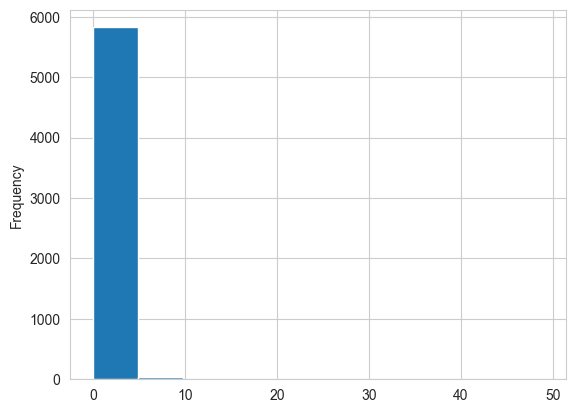

In [278]:
user_profile_div_df.user_n_brands.plot(kind='hist')

In [279]:
# user_profile_div_df.n_seen_items.plot(kind='hist')

In [280]:
user_profile_div_df.n_seen_items.value_counts()

1     3057
2      765
3      487
4      319
5      248
      ... 
60       1
57       1
56       1
55       1
40       1
Name: n_seen_items, Length: 77, dtype: int64

# get user list and add to reclist_diversity

In [247]:
reclist_div_df

,bucket_idx,holdout_idx,reclist_idx,intra_list_n_brands,intra_list_n_brands_minmax
0,b0,h0,0,2.0,0.250
1,b0,h0,1,0.0,0.000
2,b0,h0,10,1.0,0.125
3,b0,h0,100,3.0,0.375
4,b0,h0,1000,0.0,0.000
...,...,...,...,...,...
77187,b3,h3,995,1.0,0.125
77188,b3,h3,996,2.0,0.250
77189,b3,h3,997,1.0,0.125
77190,b3,h3,998,0.0,0.000


In [248]:
holdouts = joblib.load(namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_fu_0.75_semesterly_holdouts.joblib')
holdouts

In [282]:
for j, hd in enumerate(holdouts[:1]):
    print(hd.userlist)

0       A3KYAT2VDRR82T
1       A3G05IEEQP0LHM
2        AHPL6R4U5WNQ4
3        ACCSZ928M4MWW
4        AO57NG302ZAQ4
             ...      
3377    A2FFZUNFXJRQO7
3378    A382OWESG9UBOU
3379    A2NOPEELVIMMF4
3380     A9ZLL6NL7HN0P
3381    A1EX0000XTYIWQ
Name: user_id, Length: 3382, dtype: object


In [293]:
reclist_div_df_b0 = reclist_div_df.loc[(reclist_div_df.bucket_idx=='b0') & (reclist_div_df.holdout_idx=='h0'),:]
reclist_div_df_b0['user_id'] = holdouts[0].userlist
reclist_div_df_b0

C:\Users\mjlav\AppData\Local\Temp\ipykernel_4776\4261351259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reclist_div_df_b0['user_id'] = holdouts[0].userlist


,bucket_idx,holdout_idx,reclist_idx,intra_list_n_brands,intra_list_n_brands_minmax,user_id
0,b0,h0,0,2.0,0.250,A3KYAT2VDRR82T
1,b0,h0,1,0.0,0.000,A3G05IEEQP0LHM
2,b0,h0,10,1.0,0.125,AHPL6R4U5WNQ4
3,b0,h0,100,3.0,0.375,ACCSZ928M4MWW
4,b0,h0,1000,0.0,0.000,AO57NG302ZAQ4
...,...,...,...,...,...,...
3377,b0,h0,995,2.0,0.250,A2FFZUNFXJRQO7
3378,b0,h0,996,1.0,0.125,A382OWESG9UBOU
3379,b0,h0,997,0.0,0.000,A2NOPEELVIMMF4
3380,b0,h0,998,2.0,0.250,A9ZLL6NL7HN0P


# group results

In [305]:
user_profile_div_df

,bucket_idx,user_id,n_seen_items,user_n_brands
0,b0,A1G1PWJWIVW6UR,6,0
1,b0,AQ4B80F0JSBNI,60,49
2,b0,A3GYWZE27QBMY7,25,0
3,b0,A2HXYN2R7W1UQW,24,18
4,b0,APKXB8GFNRKEF,4,3
...,...,...,...,...
5880,b0,AOYBP47YAZ192,1,0
5881,b0,A3ETTRL6MY546F,1,0
5882,b0,A2Z9HDTNB6PJHX,1,0
5883,b0,A24T6NPYAEJOJW,1,0


In [299]:
reclist_div_df_b0.user_id.value_counts()

A1VGHEI55DU870    1
A1DNR85TJIQJIO    1
AJ1UH8HBMT0W      1
A2BOGMU1F6T100    1
A14GK0E64J0WAS    1
                 ..
A3A57GX8FJ4QNQ    1
A2LBHVGMUK36CF    1
A1QF91DB6BBPTR    1
A1GU45EV19T0YW    1
A11QYGVZ3CKNDT    1
Name: user_id, Length: 3382, dtype: int64

In [288]:
user_profile_div_df.user_id.value_counts()

A1VGHEI55DU870    1
A56Q5QOGAB5BT     1
A38LSX17NYPGF4    1
A323UKJE3YSH6N    1
A1GICMT1A0Q8P     1
                 ..
A31JTT31WQ22BT    1
A3LDZ4MC8DVFRL    1
A3A57GX8FJ4QNQ    1
A1AVL8TRVC5PZ4    1
A3VTISI1FU67MP    1
Name: user_id, Length: 5885, dtype: int64

# diversity dataframe

In [302]:
reclist_div_df_b0

,bucket_idx,holdout_idx,reclist_idx,intra_list_n_brands,intra_list_n_brands_minmax,user_id
0,b0,h0,0,2.0,0.250,A3KYAT2VDRR82T
1,b0,h0,1,0.0,0.000,A3G05IEEQP0LHM
2,b0,h0,10,1.0,0.125,AHPL6R4U5WNQ4
3,b0,h0,100,3.0,0.375,ACCSZ928M4MWW
4,b0,h0,1000,0.0,0.000,AO57NG302ZAQ4
...,...,...,...,...,...,...
3377,b0,h0,995,2.0,0.250,A2FFZUNFXJRQO7
3378,b0,h0,996,1.0,0.125,A382OWESG9UBOU
3379,b0,h0,997,0.0,0.000,A2NOPEELVIMMF4
3380,b0,h0,998,2.0,0.250,A9ZLL6NL7HN0P


In [306]:
# diversity_df = pd.merge(reclist_div_df_b0[['user_id', rec_div_col, rec_div_col_minmax]],
#                         user_profile_div_df[['user_id', user_profile_size_col, user_div_col]],
#                         how='left')

diversity_df = pd.merge(reclist_div_df_b0,
                        user_profile_div_df,
                        how='left')

diversity_df

,bucket_idx,holdout_idx,reclist_idx,intra_list_n_brands,intra_list_n_brands_minmax,user_id,n_seen_items,user_n_brands
0,b0,h0,0,2.0,0.250,A3KYAT2VDRR82T,4,0
1,b0,h0,1,0.0,0.000,A3G05IEEQP0LHM,1,0
2,b0,h0,10,1.0,0.125,AHPL6R4U5WNQ4,4,0
3,b0,h0,100,3.0,0.375,ACCSZ928M4MWW,2,0
4,b0,h0,1000,0.0,0.000,AO57NG302ZAQ4,3,0
...,...,...,...,...,...,...,...,...
3377,b0,h0,995,2.0,0.250,A2FFZUNFXJRQO7,19,0
3378,b0,h0,996,1.0,0.125,A382OWESG9UBOU,9,0
3379,b0,h0,997,0.0,0.000,A2NOPEELVIMMF4,49,0
3380,b0,h0,998,2.0,0.250,A9ZLL6NL7HN0P,1,0


___________________

# deprecated

## scale diversity values

In [ ]:
# reclist_N = len(rec_lists_b0_h0[0])
# reclist_N

In [ ]:
# # col = ['bucket_idx','holdout_idx','reclist_idx','item_id','score','n_brand','brand']
# rec_list_df = pd.DataFrame(columns= ['bucket_idx','holdout_idx','reclist_idx', 'item_id', 'score'])

# for b_idx in range(4):
#     for h_idx in range(4):
#         rec_lists = joblib.load(diversity_filepath+'rec_lists_b'+str(b_idx)+'_h'+str(h_idx)+'.joblib')
#         _ = convert_reclist_to_frame(rec_lists, b_idx, h_idx)
#         rec_list_df = pd.concat([rec_list_df, _])
#         print(rec_list_df)


# meta_rec = pd.merge(rec_list_df, 
#                     meta_dm, 
#                     how='left')
# meta_rec.loc[meta_rec[namepaths['item_col']].isna(), 'item_id'] = '0'
# meta_rec.loc[meta_rec[div_col].isna(), div_col] = 0
# meta_rec.loc[meta_rec.brand.isna(), 'brand'] = '0'
# reclist_div = meta_rec[['bucket_idx','holdout_idx','reclist_idx',div_col]]\
#                 .groupby(['bucket_idx','holdout_idx','reclist_idx'])\
#                     .sum().reset_index()
        

In [ ]:
# meta_rec = pd.merge(rec_list_df, 
#                     meta_dm, 
#                     how='left')
# meta_rec.loc[meta_rec[namepaths['item_col']].isna(), 'item_id'] = '0'
# meta_rec.loc[meta_rec[div_col].isna(), div_col] = 0
# meta_rec.loc[meta_rec.brand.isna(), 'brand'] = '0'
# reclist_div = meta_rec[['bucket_idx','holdout_idx','reclist_idx',div_col]]\
#                 .groupby(['bucket_idx','holdout_idx','reclist_idx'])\
#                     .sum().reset_index()

# rec_div_col = 'intra_list_n_brands'
# reclist_div.columns = ['bucket_idx','holdout_idx','reclist_idx', rec_div_col]
# reclist_div

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# recdiv_scaller = MinMaxScaler(feature_range=(0,1))
# recdiv_scaller.fit(diversity_df[[rec_div_col]])
# recdiv_scaller.data_max_


In [ ]:
# https://stackoverflow.com/questions/54168756/minmax-scaler-on-list-of-dataframes
# So, assuming that your list of DataFrames is in dfList, probably you should:
# Call fit(pd.concat(dfList)) to set min/max values, based on result of all experiments.

In [ ]:
# diversity_df[rec_div_col].unique()

In [ ]:
# recdiv_scaller = MinMaxScaler(feature_range=(0,1))
# recdiv_scaller.fit([[meta_dm.n_brand.min()*20, meta_dm.n_brand.max()*20]])
# recdiv_scaller.data_max_

In [ ]:
# recdiv_scaller.transform(diversity_df[[rec_div_col]])

end of scale diversity deprecated
________________________

In [307]:
model_data_b3 = joblib.load(diversity_filepath+'model_data_b3.joblib')

# user_div_col = 'user_n_brands'

user_profile_div_df_b3 = get_user_profile_div_frame(user_div_col, 
                                                    user_profile_size_col,
                                                    model_data_b3,
                                                    'b3', 
                                                    meta_dm)
print(user_profile_div_df_b3)

print(user_profile_div_df_b3.user_n_brands.max())
print(user_profile_div_df_b3.user_n_brands.min())

     bucket_idx         user_id n_seen_items user_n_brands
0            b3  A1G1PWJWIVW6UR           34             0
1            b3   AQ4B80F0JSBNI          108            81
2            b3  A3GYWZE27QBMY7           27             0
3            b3  A2HXYN2R7W1UQW           51            34
4            b3   APKXB8GFNRKEF            4             3
...         ...             ...          ...           ...
7348         b3  A34JBS07NO374F            1             0
7349         b3  A3RJMFAS2MC957            1             0
7350         b3  A2N6RNHQJ65T0F            1             0
7351         b3   A72M8SEO1J0PS            1             0
7352         b3  A2PJC5AOS75K2H            1             1

[7353 rows x 4 columns]
9
0


_____
## understanding qcut and cut

In [ ]:
# diversity_df.n_seen_items.unique()

In [ ]:
# diversity_df.n_seen_items.quantile()

In [ ]:
# diversity_df.n_seen_items.value_counts()/diversity_df.shape[0]

In [ ]:
# diversity_df.n_seen_items

In [ ]:
# pd.qcut(diversity_df.n_seen_items, 3, retbins=True)

In [ ]:
# _, b = pd.qcut(diversity_df.n_seen_items, 3, retbins=True, labels=False)#, duplicates='drop')
# print(_)
# print(set(_))
# print(b)
# print(set(b[_]))
# print(set(b[1:][_]))

In [ ]:
# _, b = pd.qcut(diversity_df.n_seen_items, 4, retbins=True, labels=False, duplicates='drop') # whithout 'drop' raises an error
# print(_)
# print(set(_))
# print(b)
# print(set(b[_]))
# print(set(b[1:][_]))

In [ ]:
# _, b = pd.qcut(diversity_df.n_seen_items, 3, retbins=True, labels=False)
# diversity_df['n_seen_items_binned_q3'] = b[1:][_]

# _, b = pd.qcut(diversity_df.n_seen_items, 4, retbins=True, labels=False, duplicates='drop')
# diversity_df['n_seen_items_binned_q4'] = b[1:][_]
# diversity_df


# # deprecated
# # diversity_df['n_seen_items_binned'] = pd.cut(diversity_df.n_seen_items, 4,  labels=[.25, .5, .75, 1.])
# # diversity_df

In [ ]:
# diversity_df.n_seen_items.unique()

In [ ]:
# diversity_df.n_seen_items_binned_q3.value_counts()

In [ ]:
# diversity_df.n_seen_items_binned_q4.value_counts()

In [ ]:
# diversity_df.drop(columns=['n_seen_items_binned_q3', 'n_seen_items_binned_q4'], inplace=True)

end of understanding
_________________________________________________

# get_col_binned()

In [338]:
def get_column_binned(df, col_name):
    ''' 
        this function adds a new column to the given dataframe
    '''

    try:
        df[col_name] = df[col_name].astype(int)
    except:
        print('Aborted! Needs to be a column dtype int!')

    try:
        _, b = pd.qcut(df[col_name], 4, retbins=True, labels=False)
    except:
        try:
            _, b = pd.qcut(df[col_name], 3, retbins=True, labels=False)
        except:
            _, b = pd.qcut(df[col_name], 4, retbins=True, labels=False, duplicates='drop')

    col_bin_name = col_name+'_binned'
    df[col_bin_name] =  b[1:][_]

    return col_bin_name #, df

In [339]:
# try:
#     _, b = pd.qcut(diversity_df.n_seen_items, 4, retbins=True, labels=False)

# except:
#     try:
#         _, b = pd.qcut(diversity_df.n_seen_items, 3, retbins=True, labels=False)
    
#     except:
#         _, b = pd.qcut(diversity_df.n_seen_items, 4, retbins=True, labels=False, duplicates='drop')

# user_profile_size_bin_col = user_profile_size_col+'_binned'
# diversity_df[user_profile_size_bin_col] = b[1:][_]
# diversity_df

# user_profile_size_bin_col, _ = get_column_binned(diversity_df, user_profile_size_col)
user_profile_size_bin_col = get_column_binned(diversity_df, user_profile_size_col)
diversity_df

,bucket_idx,holdout_idx,reclist_idx,intra_list_n_brands,intra_list_n_brands_minmax,user_id,n_seen_items,user_n_brands,n_seen_items_binned,user_n_brands_binned
0,b0,h0,0,2.0,0.250,A3KYAT2VDRR82T,4,0,4.0,19.0
1,b0,h0,1,0.0,0.000,A3G05IEEQP0LHM,1,0,2.0,19.0
2,b0,h0,10,1.0,0.125,AHPL6R4U5WNQ4,4,0,4.0,19.0
3,b0,h0,100,3.0,0.375,ACCSZ928M4MWW,2,0,2.0,19.0
4,b0,h0,1000,0.0,0.000,AO57NG302ZAQ4,3,0,4.0,19.0
...,...,...,...,...,...,...,...,...,...,...
3377,b0,h0,995,2.0,0.250,A2FFZUNFXJRQO7,19,0,279.0,19.0
3378,b0,h0,996,1.0,0.125,A382OWESG9UBOU,9,0,279.0,19.0
3379,b0,h0,997,0.0,0.000,A2NOPEELVIMMF4,49,0,279.0,19.0
3380,b0,h0,998,2.0,0.250,A9ZLL6NL7HN0P,1,0,2.0,19.0


In [326]:
diversity_df[user_div_col].value_counts()/diversity_df.shape[0]

0     0.878770
1     0.064755
2     0.023063
3     0.011827
4     0.005027
5     0.003548
8     0.002661
6     0.002661
9     0.001774
7     0.000887
16    0.000887
11    0.000887
12    0.000887
10    0.000887
14    0.000591
15    0.000296
19    0.000296
18    0.000296
Name: user_n_brands, dtype: float64

_____
more understanding of qcut and cut

In [ ]:
# pd.qcut(diversity_df[user_div_col], 4, retbins=True, labels=False, duplicates='drop')

In [ ]:
# # Cut!!! not qcut
# _, b = pd.cut(diversity_df[user_div_col], 4, retbins=True, labels=False, duplicates='drop')#,  labels=[.25, .5, .75, 1.])
# print(_)
# print(set(_))
# print(b)
# print(set(b[_]))
# print(set(b[1:][_]))

In [ ]:
# diversity_df[user_div_col]

In [ ]:
# _, b = pd.qcut(diversity_df[user_div_col], 4, retbins=True, labels=False, duplicates='drop')
# print(_)
# print(set(_))
# print(b)
# print(set(b[_]))
# print(set(b[1:][_]))


end of understanding
_______________

In [343]:
# try:
#     _, b = pd.qcut(diversity_df[user_div_col], 4, retbins=True, labels=False)

# except:
#     try:
#         _, b = pd.qcut(diversity_df[user_div_col], 3, retbins=True, labels=False)
    
#     except:
#         _, b = pd.qcut(diversity_df[user_div_col], 4, retbins=True, labels=False, duplicates='drop')


# user_div_bin_col = user_div_col+'_binned'
# diversity_df[user_div_col+'_binned'] = b[1:][_]
# diversity_df


# user_div_bin_col, _ = get_column_binned(diversity_df, user_div_col)

user_div_bin_col = get_column_binned(diversity_df, user_div_col)
diversity_df

,bucket_idx,holdout_idx,reclist_idx,intra_list_n_brands,intra_list_n_brands_minmax,user_id,n_seen_items,user_n_brands,n_seen_items_binned,user_n_brands_binned
0,b0,h0,0,2.0,0.250,A3KYAT2VDRR82T,4,0,4.0,19.0
1,b0,h0,1,0.0,0.000,A3G05IEEQP0LHM,1,0,2.0,19.0
2,b0,h0,10,1.0,0.125,AHPL6R4U5WNQ4,4,0,4.0,19.0
3,b0,h0,100,3.0,0.375,ACCSZ928M4MWW,2,0,2.0,19.0
4,b0,h0,1000,0.0,0.000,AO57NG302ZAQ4,3,0,4.0,19.0
...,...,...,...,...,...,...,...,...,...,...
3377,b0,h0,995,2.0,0.250,A2FFZUNFXJRQO7,19,0,279.0,19.0
3378,b0,h0,996,1.0,0.125,A382OWESG9UBOU,9,0,279.0,19.0
3379,b0,h0,997,0.0,0.000,A2NOPEELVIMMF4,49,0,279.0,19.0
3380,b0,h0,998,2.0,0.250,A9ZLL6NL7HN0P,1,0,2.0,19.0


In [355]:
def get_avg_recdiv_per_bin(df, rec_div_col, bin_col):
    avg_recdiv_bin_col = 'avg_'+rec_div_col+'_per_'+bin_col
    avg_recdiv_per_bin = df[['bucket_idx','holdout_idx',bin_col, rec_div_col]]\
                            .groupby(['bucket_idx','holdout_idx', bin_col])\
                                .mean().reset_index()
    avg_recdiv_per_bin.columns = ['bucket_idx','holdout_idx',bin_col, avg_recdiv_bin_col]
    return avg_recdiv_per_bin, avg_recdiv_bin_col

In [357]:
# avg_recdiv_profilebin_col = 'avg_'+rec_div_col+'_per_'+user_profile_size_bin_col
# avg_recdiv_per_profilebin = diversity_df[[user_profile_size_bin_col, rec_div_col]].groupby(user_profile_size_bin_col).mean().reset_index()
# avg_recdiv_per_profilebin.columns = [user_profile_size_bin_col, avg_recdiv_profilebin_col]
# avg_recdiv_per_profilebin

print('scaled:\n',get_avg_recdiv_per_bin(diversity_df, rec_div_col_minmax, user_profile_size_bin_col))
print('NOT scaled:\n',get_avg_recdiv_per_bin(diversity_df, rec_div_col, user_profile_size_bin_col))

print('the chosen:')
avg_recdiv_per_profilebin_df, avg_recdiv_profilebin_col = get_avg_recdiv_per_bin(diversity_df,
                                                                                 rec_div_col_minmax, 
                                                                                 user_profile_size_bin_col)
avg_recdiv_per_profilebin_df

scaled:
 (  bucket_idx holdout_idx  n_seen_items_binned  \
0         b0          h0                  2.0   
1         b0          h0                  4.0   
2         b0          h0                279.0   

   avg_intra_list_n_brands_minmax_per_n_seen_items_binned  
0                                           0.148283       
1                                           0.137835       
2                                           0.140882       , 'avg_intra_list_n_brands_minmax_per_n_seen_items_binned')
NOT scaled:
 (  bucket_idx holdout_idx  n_seen_items_binned  \
0         b0          h0                  2.0   
1         b0          h0                  4.0   
2         b0          h0                279.0   

   avg_intra_list_n_brands_per_n_seen_items_binned  
0                                         1.186262  
1                                         1.102679  
2                                         1.127057  , 'avg_intra_list_n_brands_per_n_seen_items_binned')
the chosen:


,bucket_idx,holdout_idx,n_seen_items_binned,avg_intra_list_n_brands_minmax_per_n_seen_items_binned
0,b0,h0,2.0,0.148283
1,b0,h0,4.0,0.137835
2,b0,h0,279.0,0.140882


In [358]:
print('scaled:\n',get_avg_recdiv_per_bin(diversity_df, rec_div_col_minmax, user_div_bin_col))
print('NOT scaled:\n',get_avg_recdiv_per_bin(diversity_df, rec_div_col, user_div_bin_col))

print('the chosen:')
avg_recdiv_per_userdivbin_df, avg_recdiv_userdivbin_col = get_avg_recdiv_per_bin(diversity_df,
                                                                                 rec_div_col_minmax, 
                                                                                 user_div_bin_col)
avg_recdiv_per_userdivbin_df

scaled:
 (  bucket_idx holdout_idx  user_n_brands_binned  \
0         b0          h0                  19.0   

   avg_intra_list_n_brands_minmax_per_user_n_brands_binned  
0                                           0.143813        , 'avg_intra_list_n_brands_minmax_per_user_n_brands_binned')
NOT scaled:
 (  bucket_idx holdout_idx  user_n_brands_binned  \
0         b0          h0                  19.0   

   avg_intra_list_n_brands_per_user_n_brands_binned  
0                                          1.150503  , 'avg_intra_list_n_brands_per_user_n_brands_binned')
the chosen:


,bucket_idx,holdout_idx,user_n_brands_binned,avg_intra_list_n_brands_minmax_per_user_n_brands_binned
0,b0,h0,19.0,0.143813


In [354]:
diversity_df = pd.merge(diversity_df, avg_recdiv_per_profilebin_df)
diversity_df = pd.merge(diversity_df, avg_recdiv_per_userdivbin_df)
diversity_df

,bucket_idx,holdout_idx,reclist_idx,intra_list_n_brands,intra_list_n_brands_minmax,user_id,n_seen_items,user_n_brands,n_seen_items_binned,user_n_brands_binned,avg_intra_list_n_brands_minmax_per_n_seen_items_binned,avg_intra_list_n_brands_minmax_per_user_n_brands_binned
0,b0,h0,0,2.0,0.250,A3KYAT2VDRR82T,4,0,4.0,19.0,0.137835,0.143813
1,b0,h0,10,1.0,0.125,AHPL6R4U5WNQ4,4,0,4.0,19.0,0.137835,0.143813
2,b0,h0,1000,0.0,0.000,AO57NG302ZAQ4,3,0,4.0,19.0,0.137835,0.143813
3,b0,h0,1007,2.0,0.250,A2AWHSNAR5OUZ4,4,0,4.0,19.0,0.137835,0.143813
4,b0,h0,1012,2.0,0.250,A3JUWJOVGU7K0K,4,0,4.0,19.0,0.137835,0.143813
...,...,...,...,...,...,...,...,...,...,...,...,...
3377,b0,h0,992,2.0,0.250,A1L1537TZP81O8,5,0,279.0,19.0,0.140882,0.143813
3378,b0,h0,993,2.0,0.250,A23FQRKY8W2MM4,9,0,279.0,19.0,0.140882,0.143813
3379,b0,h0,995,2.0,0.250,A2FFZUNFXJRQO7,19,0,279.0,19.0,0.140882,0.143813
3380,b0,h0,996,1.0,0.125,A382OWESG9UBOU,9,0,279.0,19.0,0.140882,0.143813


<AxesSubplot:xlabel='user_n_brands_binned', ylabel='avg_intra_list_n_brands_minmax_per_user_n_brands_binned'>

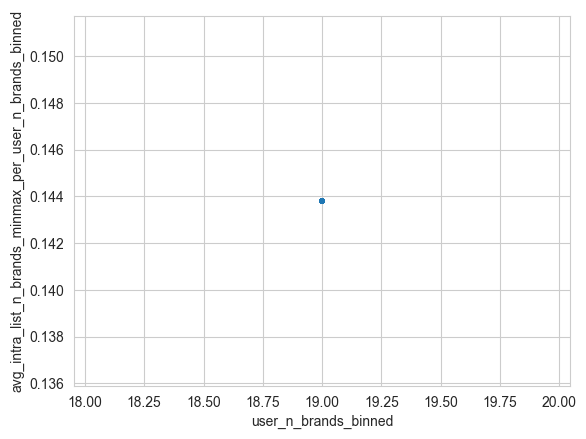

In [375]:
diversity_df[['user_n_brands_binned', avg_recdiv_userdivbin_col]].plot(x='user_n_brands_binned',
                                                            y=avg_recdiv_userdivbin_col,
                                                            kind='scatter',
                                                            marker='+')

In [376]:
diversity_df[['user_n_brands_binned', avg_recdiv_userdivbin_col]].value_counts()

user_n_brands_binned  avg_intra_list_n_brands_minmax_per_user_n_brands_binned
19.0                  0.143813                                                   3382
dtype: int64

<AxesSubplot:xlabel='n_seen_items_binned', ylabel='avg_intra_list_n_brands_minmax_per_user_n_brands_binned'>

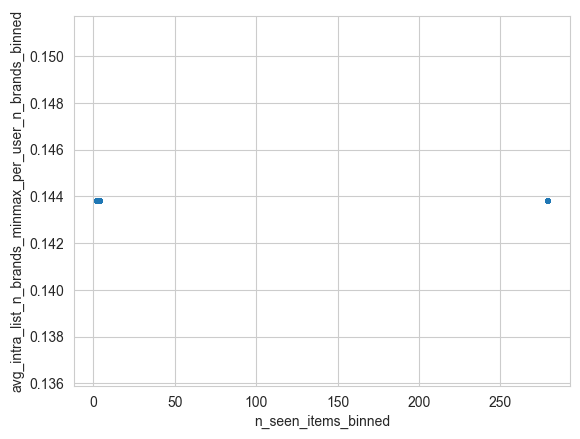

In [369]:
diversity_df[['n_seen_items_binned', avg_recdiv_userdivbin_col]].plot(x='n_seen_items_binned',
                                                            y=avg_recdiv_userdivbin_col,
                                                            kind='scatter',
                                                            marker='+')#,
                                                            # xlim=[0,1.05])

In [363]:
diversity_df[['n_seen_items_binned', avg_recdiv_userdivbin_col]].value_counts()

n_seen_items_binned  avg_intra_list_n_brands_minmax_per_user_n_brands_binned
2.0                  0.143813                                                   1616
279.0                0.143813                                                   1094
4.0                  0.143813                                                    672
dtype: int64

<AxesSubplot:xlabel='n_seen_items', ylabel='user_n_brands'>

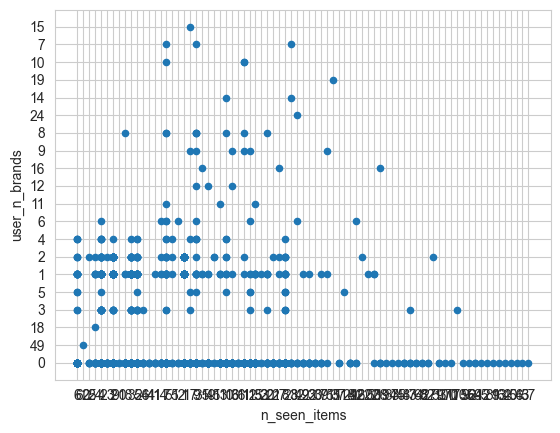

In [374]:
#.set_index('user_id')
user_profile_div_df[['user_id','n_seen_items','user_n_brands']].plot(x='n_seen_items',
                                                                  y='user_n_brands',
                                                                  kind='scatter')

# optimise to read holdouts and buckets

In [390]:
# _ = reclist_div_df.copy()
# _['reclist_idx'] = _['reclist_idx'].astype(int)
# _.set_index(['bucket_idx','holdout_idx','reclist_idx'], inplace=True)
# _.sort_index()

In [72]:
import os
def validate_folderpath(folderpath):
    if not os.path.exists(folderpath):
        os.makedirs(folderpath)


def save_plot(title, bi, hj, df, x, y, path):
    full_title = title+'- B'+str(bi)+'H'+str(hj)
    ax = df.loc[islice['b'+str(bi), 'h'+str(hj), :], [x, y]]\
                .plot(  x=x,
                        y=y,
                        kind='scatter',
                        marker='+',
                        title=title)
    fig = ax.get_figure()
    fig.savefig(path+full_title+'.png')

In [ ]:
# got the profile size from the wrong model

# %time


# diversity_filepath = namepaths['output_path']+'eval_files/'
# sample_str = 'sample_2014-06_until_2016-11+cold_start_positive_rates_fu_0.75_semesterly'


# div_col = 'n_brand'
# meta_dm = pd.read_csv(namepaths['output_path']+'meta_amazon_digitalmusic.csv')
# meta_dm.columns = ['item_id', div_col, 'brand']

# # 'bucket_idx','holdout_idx',

# # print('load all holdouts')
# holdouts = joblib.load(namepaths['output_path']+sample_str+'_holdouts.joblib')

# for bi in range(len(holdouts)):

#     print('load model\'s data @bucket'+str(bi))
#     model_data = joblib.load(diversity_filepath+'model_data_b'+str(bi)+'.joblib')


#     #print('calculate user profile diversity and length')
#     user_div_col = 'user_n_brands'
#     user_profile_cols = ['user_id', 'n_seen_items', user_div_col]
#     user_profile_div = pd.DataFrame(columns=user_profile_cols)
#     for u in (model_data.userset):
#         # df (u, n_seen_items, sum=diversity)
#         user_profile = model_data.GetUserItems(u, internal=False)
#         div = meta_dm.loc[meta_dm['item_id'].isin(user_profile), div_col].sum()
#         user_profile_div.loc[len(user_profile_div),:] = [u, len(user_profile), div]



#     for hi in range(len(holdouts)):
        
#         # print('load rec lists @holdout '+str(hi))
#         rec_lists = joblib.load(diversity_filepath+'rec_lists_b'+str(bi)+'_h'+str(hi)+'.joblib')
#         # print('number of rec lists:', len(rec_lists))


#         # print('convert recommendation lists file to dataframe')
#         rl_col = ['reclist_idx', 'item_id', 'score']
#         reclists_df = pd.DataFrame(columns=rl_col)
#         for i, rl in enumerate(rec_lists):
#             _ = pd.DataFrame(rl, columns = ['item_id', 'score'])
#             _[rl_col[0]] = i
#             reclists_df = pd.concat([reclists_df, _])   


#         # print('add side info to rec list frame')
#         meta_reclist = pd.merge(reclists_df, 
#                             meta_dm, 
#                             how='left')
#         # print('fill in Na values')
#         meta_reclist.loc[meta_reclist['item_id'].isna(), 'item_id'] = '0'
#         meta_reclist.loc[meta_reclist[div_col].isna(), div_col] = 0
#         meta_reclist.loc[meta_reclist.brand.isna(), 'brand'] = '0'


#         # print('calculate the diversity for each recommendation list')
#         reclist_div = meta_reclist[['reclist_idx',div_col]]\
#                 .groupby(['reclist_idx'])\
#                     .sum().reset_index()

#         rec_div_col = 'intra_list_n_brands'
#         reclist_div.columns = ['reclist_idx', rec_div_col]
#         # print('add user id to reclist_div')
#         reclist_div['user_id'] = holdouts[hi].userlist

        
#         # print('group results per quartiles')
#         org_bin_col = 'n_seen_items'
#         bin_col = org_bin_col+'_binned'

#         diversity_df = pd.merge(reclist_div[['user_id', rec_div_col]],
#                                 user_profile_div[['user_id','n_seen_items', user_div_col]],
#                                 how='left')
#         diversity_df[bin_col] = pd.cut(diversity_df[org_bin_col], 4,  labels=[.25, .5, .75, 1.])
        
#         print('calculate the average intra list diversity per group')
#         avg_rec_div_col = 'avg_'+rec_div_col
#         avg_intra_list_div_per_bin = diversity_df[[bin_col, rec_div_col]].groupby(bin_col).mean().reset_index()
#         avg_intra_list_div_per_bin.columns = [bin_col, avg_rec_div_col]
        
#         diversity_df = pd.merge(diversity_df, avg_intra_list_div_per_bin)
        

#         diversity_df[[bin_col, avg_rec_div_col]].plot(x=bin_col,
#                                                       y=avg_rec_div_col,
#                                                       kind='scatter',
#                                                       xlim=[0,1.05],
#                                                       title='Profile size vs Avg intra-list diversity - B'+str(bi)+'H'+str(hi));
        

